# Feature evaluation
This notebook explores the engeineered features.

## Load dependencies

In [3]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from definitions import GEN_PATH, ROOT_DIR

sns.set_context('notebook')
sns.set_style('white')

## Load processed data

In [4]:
# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

## Extract training and validation data
Test data should not be used, even in, feature evaluation.

In [5]:
# Split data set into train and test
# Start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Testing will be done on 2019 matches
data_train = data.loc[data.tourney_date < test_date_begin]
data_train = pd.get_dummies(data_train, columns=['home_advantage'])

renames = {
    'home_advantage_-1': 'p2_home',
    'home_advantage_0': 'none_home',
    'home_advantage_1': 'p1_home',
}

data_train.rename(columns=renames, inplace=True)

## OPTIONAL: Removing low level matches
Testing to remove low level matches to see if different
is present for tour level matches. This means train and evaluate 
on only tour matches

In [40]:
tourneys = [2,3,5,6]
data_mask = (data_train.tourney_level.isin(tourneys))
data_train = data_train.loc[data_mask]

## Split data set into validation and training part

In [12]:
drop_cols = ['outcome', 'tourney_date', 'tourney_level']
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

display(X_train)

,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,p2_home,none_home,p1_home
53769,1.183027,1.917013,-0.000355,-0.000216,0.000682,-1.809413,0.043623,1.524548,1.332776,-0.001289,0,1,0
115300,-1.453717,-1.339051,-0.000355,-0.000216,0.000682,2.100724,-0.024018,-1.341954,-0.363093,-0.001289,0,0,1
116221,-0.162251,0.088265,-0.000355,-0.000216,0.000682,-0.037138,0.003298,-0.278574,-0.363093,1.016201,1,0,0
66096,-0.969417,-0.536186,-0.000355,-0.000216,0.000682,-0.004040,0.000697,1.755718,0.833991,-0.001289,0,1,0
95068,0.644916,-0.134753,-0.000355,-0.000216,0.000682,-0.966905,0.281669,1.062209,-0.163579,-0.001289,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.860160,0.088265,-0.000355,-0.000216,0.000682,-1.857556,0.202320,0.461168,0.368458,-0.001289,0,1,0
103694,-1.399906,-0.669996,-0.000355,-0.000216,0.000682,0.778289,-0.012311,0.137531,1.332776,-1.745557,0,1,0
860,-0.969417,-1.740483,-0.000355,-0.000216,0.000682,0.089238,-0.120277,-1.388188,-0.562607,-0.001289,0,1,0
15795,1.667327,0.222076,-0.000355,-0.000216,0.000682,-1.836493,0.086549,1.848186,2.330346,-0.001289,1,0,0


## OPTIONAL: Remove correlated features

In [15]:
col_remove = ['rel_total_wins', 'mutual_wins', 'mutual_surface_wins', 'rel_climate_wins']
X_train.drop(col_remove, inplace=True, axis=1)
X_val.drop(col_remove, inplace=True, axis=1)

## Correlation heatmap

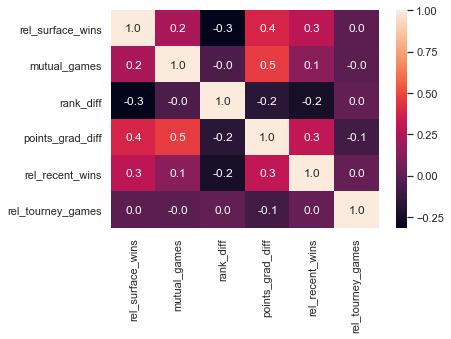

In [11]:
adv = ['p2_home', 'none_home', 'p1_home']
X_heat = X_train.drop(adv, axis=1)
sns.heatmap(X_heat.corr(), annot=True, fmt='.1f')
plt.show()

## Feature importance
Question being answered: which features help split our tree in the best way possible?
How does each feature affect the accuracy of our model?

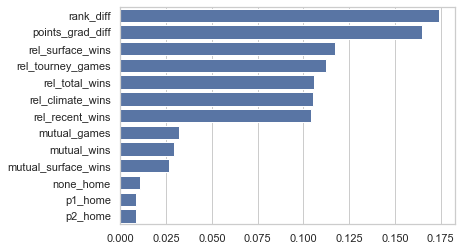

In [13]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

sns.set(style="whitegrid")
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
plt.show()

## Recursive feature elimination by feature importance
This takes a bit of time (large set...). 
Prune the results from previous sections. 
A ranking of 1 means the algorithm suggests the feature.
Remove highly correlated feature first

In [11]:
model = RandomForestClassifier()
rfe_model = RFE(model)  # selects 5 features
rfe_model.fit(X_train, y_train)

rfe_results = pd.DataFrame(rfe_model.ranking_, index=X_train.columns, columns=['ranking'])

display(rfe_results)
print('\nNumber of features selected: %d' % rfe_model.n_features_)

,ranking
rel_total_wins,2
rel_surface_wins,1
mutual_wins,4
mutual_surface_wins,5
mutual_games,3
rank_diff,1
points_grad_diff,1
rel_climate_wins,1
rel_recent_wins,1
rel_tourney_games,1



Number of features selected: 6


## Classification report

Full model:

In [16]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

full_val_pred = model.predict(X_val)
class_report_full = classification_report(y_val, full_val_pred)
print(class_report_full)

              precision    recall  f1-score   support

          -1       0.72      0.72      0.72     20351
           1       0.72      0.72      0.72     20119

    accuracy                           0.72     40470
   macro avg       0.72      0.72      0.72     40470
weighted avg       0.72      0.72      0.72     40470



Reduced model:
Run script above due to it being so slow

In [12]:
red_val_pred = rfe_model.predict(X_val)
class_report_red = classification_report(y_val, red_val_pred)
print(class_report_red)

              precision    recall  f1-score   support

          -1       0.72      0.72      0.72     20351
           1       0.72      0.72      0.72     20119

    accuracy                           0.72     40470
   macro avg       0.72      0.72      0.72     40470
weighted avg       0.72      0.72      0.72     40470



## Specific cases
Federer vs. Nadal

Need to extract id data

## Performance on ATP main matches
Same matches as being tested, ATP 250, 500 and 1000

In [41]:
tourneys = [2,3]

drop_cols = ['outcome', 'tourney_date']
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

X_val = X_val.join(y_val)
data_mask = (X_val.tourney_level.isin(tourneys))
X_val = X_val.loc[data_mask]
y_val = X_val.outcome
X_val.drop(['outcome', 'tourney_level'], inplace=True, axis=1)

X_train.drop('tourney_level', inplace=True, axis=1)

model = RandomForestClassifier()
model.fit(X_train, y_train)

full_val_pred = model.predict(X_val)
class_report_full = classification_report(y_val, full_val_pred)
print(class_report_full)

              precision    recall  f1-score   support

          -1       0.68      0.70      0.69      1952
           1       0.68      0.66      0.67      1868

    accuracy                           0.68      3820
   macro avg       0.68      0.68      0.68      3820
weighted avg       0.68      0.68      0.68      3820



## Accuracy increase over time?
i.e. should we generate more statistics?

In [17]:
drop_cols = ['outcome', 'tourney_date', 'tourney_level']

# 2017-12-31: 1514678400, 2016-12-31: 1483142400, 2015-12-31: 1451520000
train_eval_split_low = 1451520000
train_eval_split_high = 1514678400

data_train_pre = data_train.loc[data_train.tourney_date < train_eval_split_low]
data_train_post = data_train.loc[data_train.tourney_date >= train_eval_split_high]

y_train_pre = data_train_pre.outcome
X_train_pre = data_train_pre.drop(drop_cols, axis=1)

y_train_post = data_train_post.outcome
X_train_post = data_train_post.drop(drop_cols, axis=1)

X_train_pre, X_val_pre, y_train_pre, y_val_pre = train_test_split(X_train_pre, y_train_pre, test_size=0.33, random_state=42)
X_train_post, X_val_post, y_train_post, y_val_post = train_test_split(X_train_post, y_train_post, test_size=0.33, random_state=42)

model_pre = RandomForestClassifier()
model_pre.fit(X_train_pre, y_train_pre)

val_pred_pre = model_pre.predict(X_val_pre)
class_report_pre = classification_report(y_val_pre, val_pred_pre)
print(class_report_pre)

model_post = RandomForestClassifier()
model_post.fit(X_train_post, y_train_post)

val_pred_post = model_post.predict(X_val_post)
class_report_post = classification_report(y_val_post, val_pred_post)
print(class_report_post)

              precision    recall  f1-score   support

          -1       0.74      0.75      0.74      5107
           1       0.75      0.73      0.74      5132

    accuracy                           0.74     10239
   macro avg       0.74      0.74      0.74     10239
weighted avg       0.74      0.74      0.74     10239

              precision    recall  f1-score   support

          -1       0.72      0.73      0.72      4925
           1       0.72      0.71      0.72      4898

    accuracy                           0.72      9823
   macro avg       0.72      0.72      0.72      9823
weighted avg       0.72      0.72      0.72      9823

